In [3]:
pip install timm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from timm import create_model
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")


📟 Device: cuda


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transformasi
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [5]:
# Ganti dengan path dataset barumu
train_dir = "dataset_vit/train"
test_dir = "dataset_vit/test"

# Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

print(f"📊 Train: {len(train_dataset)} | Test: {len(test_dataset)}")
print(f"📂 Classes: {train_dataset.classes}")

📊 Train: 77771 | Test: 33335
📂 Classes: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


In [6]:
# Ganti dengan path dataset barumu
train_dir = "dataset_vit_aug/train"
test_dir = "dataset_vit/test"

# Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

print(f"📊 Train: {len(train_dataset)} | Test: {len(test_dataset)}")
print(f"📂 Classes: {train_dataset.classes}")


📊 Train: 150992 | Test: 33335
📂 Classes: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


In [7]:
from torch.utils.data import random_split

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

print(f"🟢 Train: {len(train_set)} | 🟡 Val: {len(val_set)}")


🟢 Train: 128343 | 🟡 Val: 22649


In [8]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
from torchvision import models
import torch.nn as nn

model = models.vit_b_16(pretrained=True)
model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.heads.head.in_features, len(train_dataset.classes))
)

model = model.to(device)
print("✅ ViT model siap di GPU")


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ViT model siap di GPU


In [10]:
import torch.optim as optim
from tqdm import tqdm
import time

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

scaler = torch.cuda.amp.GradScaler()


C:\Users\pravi\AppData\Local\Temp\ipykernel_34292\1656142058.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [11]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc=f"🚀 Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    acc = correct / total_samples * 100
    avg_loss = total_loss / len(train_loader)
    mins, secs = divmod(time.time() - start_time, 60)
    print(f"✅ Epoch {epoch+1} selesai - Loss: {avg_loss:.4f} - 🎯 Akurasi: {acc:.2f}% - ⏱️ Durasi: {int(mins)}m {int(secs)}s")
    print(f"📈 GPU Mem Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


🚀 Epoch [1/5]:   0%|          | 0/4011 [00:00<?, ?it/s]C:\Users\pravi\AppData\Local\Temp\ipykernel_26908\1934672397.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
🚀 Epoch [1/5]: 100%|██████████| 4011/4011 [31:32<00:00,  2.12it/s, loss=0.281]  


✅ Epoch 1 selesai - Loss: 0.1426 - 🎯 Akurasi: 95.50% - ⏱️ Durasi: 31m 32s
📈 GPU Mem Used: 1343.92 MB


🚀 Epoch [2/5]: 100%|██████████| 4011/4011 [31:39<00:00,  2.11it/s, loss=0.231]  


✅ Epoch 2 selesai - Loss: 0.0789 - 🎯 Akurasi: 97.53% - ⏱️ Durasi: 31m 39s
📈 GPU Mem Used: 1343.92 MB


🚀 Epoch [3/5]: 100%|██████████| 4011/4011 [31:39<00:00,  2.11it/s, loss=0.0184] 


✅ Epoch 3 selesai - Loss: 0.0660 - 🎯 Akurasi: 97.89% - ⏱️ Durasi: 31m 39s
📈 GPU Mem Used: 1343.92 MB


🚀 Epoch [4/5]: 100%|██████████| 4011/4011 [32:01<00:00,  2.09it/s, loss=0.125]   


✅ Epoch 4 selesai - Loss: 0.0546 - 🎯 Akurasi: 98.26% - ⏱️ Durasi: 32m 1s
📈 GPU Mem Used: 1343.92 MB


🚀 Epoch [5/5]: 100%|██████████| 4011/4011 [32:01<00:00,  2.09it/s, loss=0.000929]

✅ Epoch 5 selesai - Loss: 0.0485 - 🎯 Akurasi: 98.42% - ⏱️ Durasi: 32m 1s
📈 GPU Mem Used: 1343.92 MB


In [12]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

# === Ambil nama kelas dari dataset ===
class_names = train_dataset.classes

# === Evaluasi Model ===
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report dan Confusion Matrix ===
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

# === Fungsi Menghitung Specificity per Kelas ===
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

# === Fungsi Menghitung Accuracy per Kelas ===
def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

# === Hitung Metrik Tambahan ===
specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)

# === Tampilkan Hasil Evaluasi ===
print(f"{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(class_names):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.44      86.22        90.05        99.66      88.09
AFIB            99.98      99.79        99.97        99.98      99.88
AFL             99.98      97.78        86.27       100.00      91.67
L               99.89      98.73        99.71        99.90      99.22
N               99.20      99.58        99.23        99.12      99.40
R               99.96      99.77        99.54        99.98      99.66
V               99.71      97.18        98.32        99.80      97.75


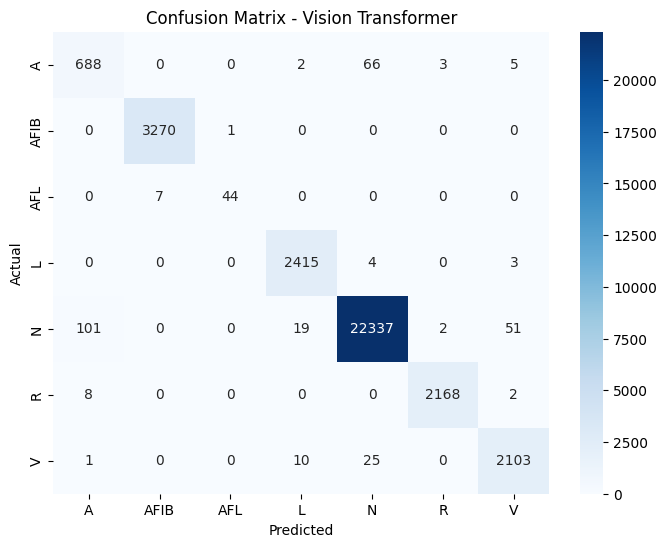

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Vision Transformer")
plt.show()


In [14]:
torch.save(model.state_dict(), "model_vit_tuning.pth")
print("📦 Model berhasil disimpan!")


📦 Model berhasil disimpan!


📟 Device: cuda
🧪 Test set dipersulit: 33335 sampel
📂 Kelas: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ViT berhasil dimuat ulang.


🔍 Evaluating on Augmented Test Set: 100%|██████████| 1042/1042 [05:57<00:00,  2.92it/s]



📈 Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.87      0.82       764
        AFIB       1.00      1.00      1.00      3271
         AFL       0.74      0.78      0.76        51
           L       0.96      0.99      0.97      2422
           N       0.99      0.98      0.99     22510
           R       0.99      0.99      0.99      2178
           V       0.93      0.97      0.95      2139

    accuracy                           0.98     33335
   macro avg       0.91      0.94      0.93     33335
weighted avg       0.98      0.98      0.98     33335



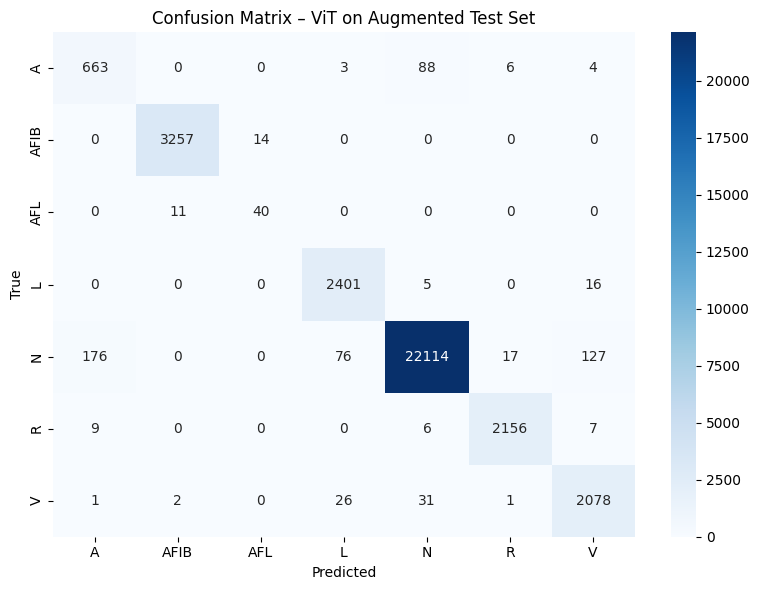


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.14      78.09        86.78        99.43      82.21
AFIB            99.92      99.60        99.57        99.96      99.59
AFL             99.93      74.07        78.43        99.96      76.19
L               99.62      95.81        99.13        99.66      97.44
N               98.42      99.42        98.24        98.80      98.82
R               99.86      98.90        98.99        99.92      98.94
V               99.36      93.10        97.15        99.51      95.08


In [16]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")

# === Path Test Dataset Sesuai Folder Kamu
test_dir = "dataset_vit/test"

# === Augmentasi Berat untuk Simulasi Kondisi Sulit
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset Test dengan Augmentasi Berat
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
classes = test_dataset.classes
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(f"🧪 Test set dipersulit: {len(test_dataset)} sampel")
print(f"📂 Kelas: {classes}")

# === Load Model ViT
model = models.vit_b_16(pretrained=True)
model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.heads.head.in_features, len(classes))
)
model.load_state_dict(torch.load("model_vit_tuning.pth"))  # ganti nama jika perlu
model = model.to(device)
model.eval()
print("✅ Model ViT berhasil dimuat ulang.")

# === Evaluasi Model
y_true, y_pred = [], []
with torch.no_grad():
    loop = tqdm(test_loader, desc="🔍 Evaluating on Augmented Test Set")
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report
print("\n📈 Classification Report:")
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ViT on Augmented Test Set")
plt.tight_layout()
plt.show()

# === Perhitungan Metrik Tambahan
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)

# === Tabel Evaluasi Per Kelas
print(f"\n{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(classes):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


In [12]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load test set
test_dir = "dataset_vit/test"
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
classes = test_dataset.classes
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Load pretrained model
model = models.vit_b_16(pretrained=False)
model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.heads.head.in_features, len(classes))
)
model.load_state_dict(torch.load("model_vit_tuning.pth"))
model = model.to(device)
model.eval()


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

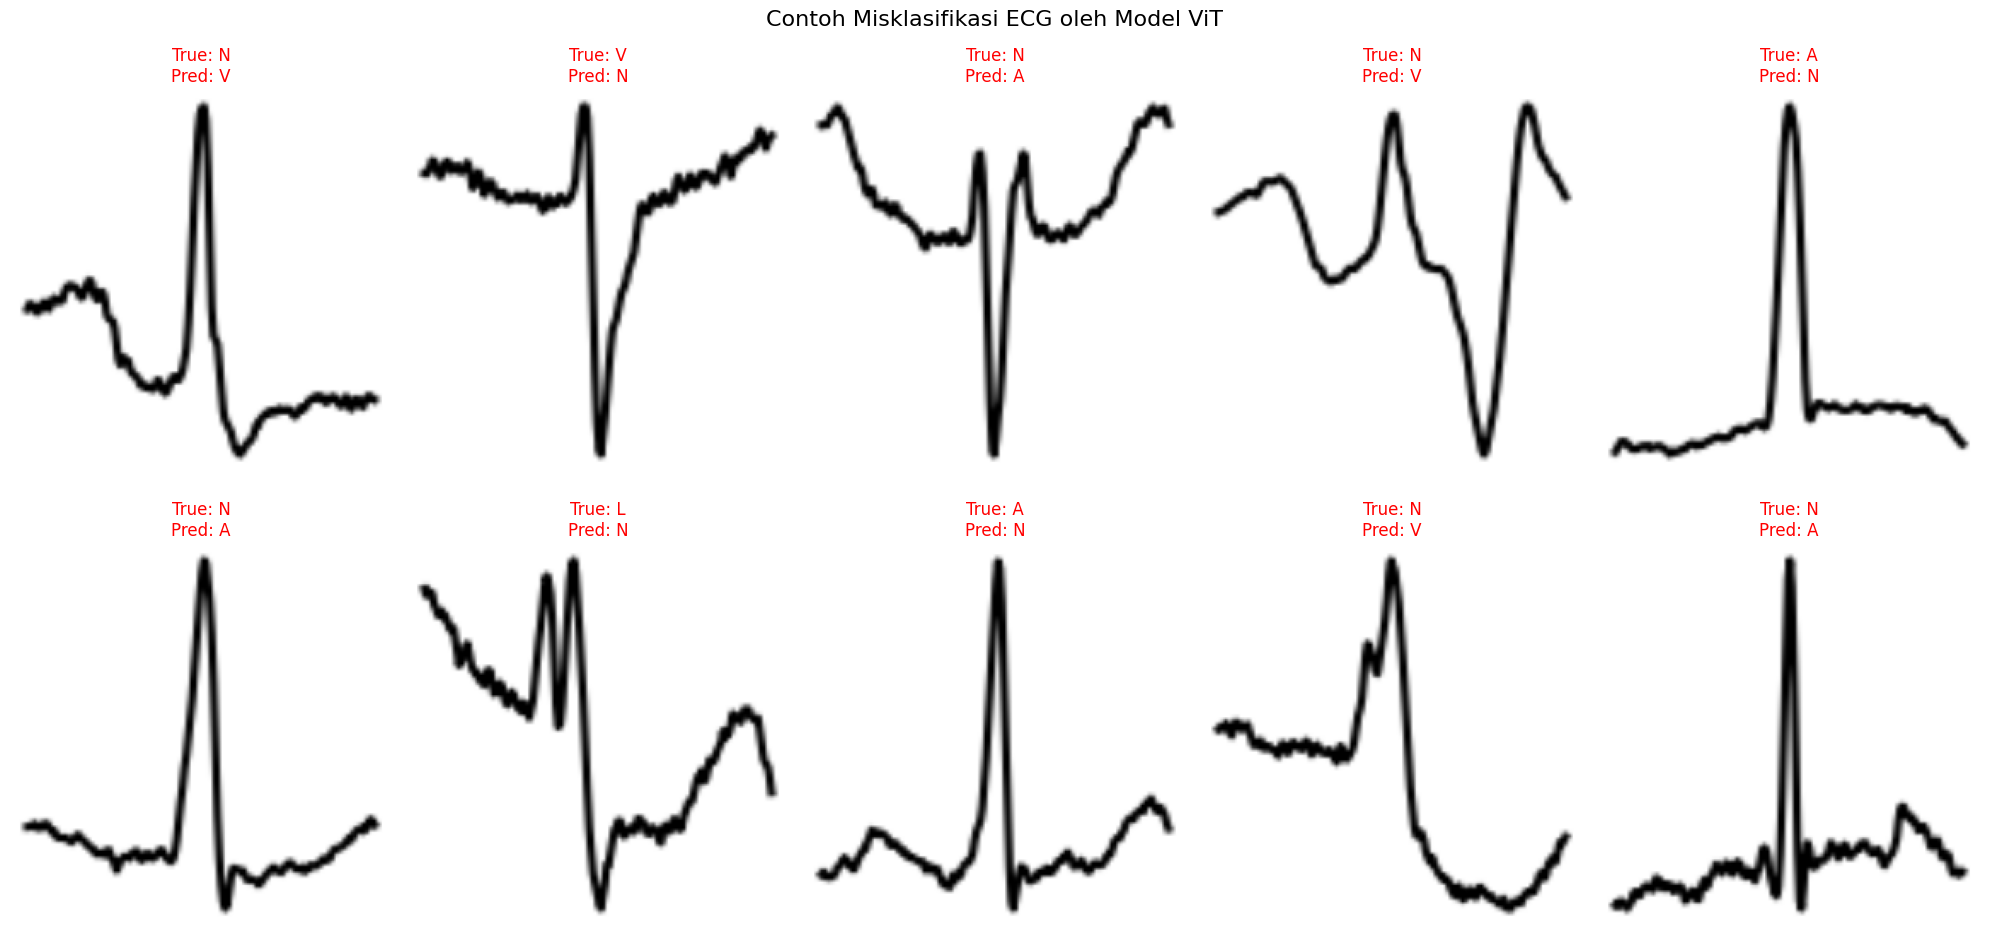

In [13]:
# === Tampilkan Contoh Misclassifications
import random

# Reset dulu untuk pencocokan
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Ulang evaluasi dengan simpan gambar
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_true_labels.append(labels[i].cpu().item())
                misclassified_pred_labels.append(preds[i].cpu().item())

# Ambil 10 sampel acak dari misclassification
sample_indices = random.sample(range(len(misclassified_images)), min(10, len(misclassified_images)))
plt.figure(figsize=(20, 10))
for idx, sample_idx in enumerate(sample_indices):
    img = misclassified_images[sample_idx]
    true_label = classes[misclassified_true_labels[sample_idx]]
    pred_label = classes[misclassified_pred_labels[sample_idx]]
    
    plt.subplot(2, 5, idx + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)) * 0.5 + 0.5)  # unnormalize
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')
plt.suptitle("Contoh Misklasifikasi ECG oleh Model ViT", fontsize=16)
plt.tight_layout()
plt.show()


📟 Device: cuda
🧪 Evaluasi di Data Train (augmented): 150992 sampel
📂 Kelas: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ViT berhasil dimuat ulang.


🔍 Evaluating on Train Set: 100%|██████████| 4719/4719 [28:16<00:00,  2.78it/s]



📈 Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.92      0.93      7128
        AFIB       1.00      1.00      1.00     30520
         AFL       0.99      0.83      0.91       464
           L       0.99      1.00      0.99     22604
           N       0.99      0.99      0.99     50000
           R       1.00      1.00      1.00     20316
           V       0.99      0.99      0.99     19960

    accuracy                           0.99    150992
   macro avg       0.99      0.96      0.97    150992
weighted avg       0.99      0.99      0.99    150992



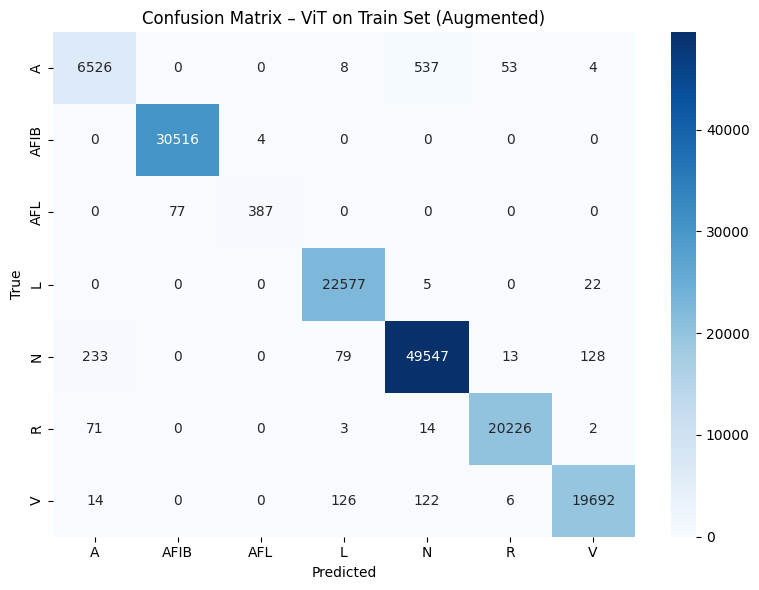


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.39      95.35        91.55        99.78      93.42
AFIB            99.95      99.75        99.99        99.94      99.87
AFL             99.95      98.98        83.41       100.00      90.53
L               99.84      99.05        99.88        99.83      99.46
N               99.25      98.65        99.09        99.33      98.87
R               99.89      99.65        99.56        99.94      99.60
V               99.72      99.21        98.66        99.88      98.93


In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")

# === Path Train Dataset (yang sudah di-augment)
train_dir = "dataset_vit_aug/train"

# === Transformasi ringan (tanpa augmentasi tambahan)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset dari data train
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
classes = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(f"🧪 Evaluasi di Data Train (augmented): {len(train_dataset)} sampel")
print(f"📂 Kelas: {classes}")

# === Load Model ViT hasil tuning
model = models.vit_b_16(pretrained=True)
model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.heads.head.in_features, len(classes))
)
model.load_state_dict(torch.load("model_vit_tuning.pth"))  # ubah path jika beda
model = model.to(device)
model.eval()
print("✅ Model ViT berhasil dimuat ulang.")

# === Evaluasi Model pada Data Train
y_true, y_pred = [], []
with torch.no_grad():
    loop = tqdm(train_loader, desc="🔍 Evaluating on Train Set")
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report
print("\n📈 Classification Report:")
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ViT on Train Set (Augmented)")
plt.tight_layout()
plt.show()

# === Perhitungan Metrik Tambahan
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)

# === Tabel Evaluasi Per Kelas
print(f"\n{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(classes):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


In [4]:
import pandas as pd
from IPython.display import display

# Data hasil evaluasi untuk Fold 1
results_fold_1 = {
    'Fold': ['Fold 1'] * 5,
    'Class': ['N', 'L', 'R', 'A', 'V'],
    'Precision': [0.985064, 0.997080, 0.994314, 0.991489, 0.979389],
    'Sensitivity': [0.985765, 0.977810, 0.997860, 0.987288, 0.998551],
    'Specificity': [0.996247, 0.999286, 0.998571, 0.997851, 0.994840],
    'F1-Score': [0.985414, 0.987351, 0.996084, 0.989384, 0.988877],
}

# Ubah ke DataFrame
df_fold_1 = pd.DataFrame(results_fold_1)

# Tampilkan tabel hasil evaluasi Fold 1
display(df_fold_1)


,Fold,Class,Precision,Sensitivity,Specificity,F1-Score
0,Fold 1,N,0.985064,0.985765,0.996247,0.985414
1,Fold 1,L,0.997080,0.977810,0.999286,0.987351
2,Fold 1,R,0.994314,0.997860,0.998571,0.996084
3,Fold 1,A,0.991489,0.987288,0.997851,0.989384
4,Fold 1,V,0.979389,0.998551,0.994840,0.988877
